In [1]:
# Imports
import numpy as np
import pandas as pd
import itertools
import os
import matplotlib.pyplot as plt
from libtiff import TIFF

In [2]:
class GaezData:
    """ Load data from GAEZv3 website. Adapted from Daniel Kondor."""
    # initialize class variables
    _ncols = 0
    _nrows = 0
    _xll, _yll = 0, 0 # reference point (southwest) for lat / long coordinates
    _csize = 0 # size of cell
    _no_data_val = 0 # value that denotes invalid data
    _values = np.array([]) # holds crop yields
    _r_km = 6371 # mean earth radius

    def _key_validate(self, k, v):
        """
        Validate one line of metadata read from the input file
        """
        if k == "ncols":
            self._ncols = int(v)
        elif k == "nrows":
            self._nrows = int(v)
        elif k == "xllcorner":
            self._xll = float(v)
        elif k == "yllcorner":
            self._yll = float(v)
        elif k == "cellsize":
            self._csize = float(v)
        elif k == "NODATA_value":
            self._no_data_val = int(v)
        else:
            raise Exception("GaezData._key_validate(): invalid metadata key!\n")

    def load(self, fn, dtype=np.int32):
        """
        Load data in a grid from the given file. Assumes .asc file format for now.
        The parameter dtype can specify the type of data in the file; it will be used to create the data matrices.
        """
        with open(fn) as f1:
            i = 0
            # first six lines are metadata # TODO: Check for future data sets
            while i < 6:
                l1 = f1.readline()
                l2 = l1.split()
                if len(l2) == 0:
                    continue
                if len(l2) != 2: # valid metadata contains two tab-separated words
                    raise Exception("GaezData.load(): invalid metadata!\n")
                self._key_validate(*l2)
                i += 1

            # check if metadata is valid
            if self._ncols <= 0 or self._nrows <= 0 or self._csize <= 0:
                raise Exception("GaezData.load(): invalid metadata!\n")

            self._values = np.zeros([self._nrows, self._ncols], dtype=dtype)
            # note: data is referenced to lower left (southwest) corner. array has origin at upper left corner.
            # note: invert row order
            for i in range(self._nrows):
                l1 = f1.readline()
                self._values[self._nrows - i - 1, :] = [dtype(y) for y in l1.split()]

    def get_value_xy(self, x, y):
        # TODO: Array support
        if x >= self._ncols or y >= self._nrows or x < 0 or y < 0:
            raise Exception("GaezData.get_value_xy(): position out of range!\n")
        return self._values[y, x]

    def lonlat_to_xy(self, lon, lat):
        """
        note: xll gives longitude (east / west) and yll latitude (north / south) of reference point
        example: lat (0, 0) = lat (reference point) = lat (xll, yll) -> (x=0, y=0)
        """
        x = int(round((lon - self._xll) / self._csize))
        y = int(round((lat - self._yll) / self._csize))
        return x, y

    def xy_to_lonlat(self, x, y):
        lon = self._xll + x * self._csize
        lat = self._yll + y * self._csize
        return lon, lat

    def get_value_lonlat(self, lon, lat):
        """
        goal: retrieve yield at given lat / lon coordinates.
        needed: convert lat / long to index (i.e. x, y) - > retrieve element at index
        """
        x, y = self.lonlat_to_xy(lon, lat)
        return self.get_value_xy(x, y)

    def get_values_in_study_area(self, xsize, ysize, off_x, off_y):
        """ Denote study area by x / y offset (convert from lat / long) and slices along x and y."""
        # create a matrix of yield values only in the study area
        slice_1d = self._values[off_y:(off_y + ysize), off_x:(off_x + xsize)]
        return slice_1d.reshape([ysize, xsize])

    def get_arc_distance(self, lat1, lat2, del_lon):
        """Get distance between the two points specified by two latitude coordinates and a relative longitude
        coordinate according to the Haversine formula."""
        # Convert to radians
        lat1 *= np.pi / 180
        lat2 *= np.pi / 180
        del_lon *= np.pi / 180

        # Apply haversine
        a = np.sin((lat1 - lat2) / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(del_lon / 2) ** 2
        c = 2 * np.atan2(np.sqrt(a), np.sqrt(1 - a))
        distance = self._r_km * c
        return distance

    def get_distance_matrx(self):
        """ Return a (M, N, N) dimensional matrix where mat[m, n1, n2] is the distance between two points with
         relative longitudinal difference m (rounded integer) and latitude coordinates l_n1, l_n2.
         Is quite memory-heavy so far."""

        # get relative distances between longitudinal (east / west) values - column
        # yields (0, self._csize, 2 * self._csize) for n_cols = 3
        lon_diff_values = np.linspace(0, self._ncols * self._csize, self._ncols, endpoint=False)

        # get latitude values - data starts in upper left corner - invert
        lat_vals = np.linspace(self._xll + self._csize * (self._nrows - 1), self._xll, self._nrows)

        # goal: we have a (n_cols, n_rows, n_rows) matrix. If we query with e.g. index (0, 0, 0),
        # we get the distance for relative long. diff 0, and for latitude vals self._xul, self._xul
        # instead of np.meshgrid(), we use numpy broadcasting to save memory
        lon_diff_values = lon_diff_values[:, None, None]
        lat_vals_1 = lat_vals[None, :, None]
        lat_vals_2 = lat_vals[None, None, :]

        # get distance - problem: We have a memory error but broadcasting works like a charm
        distance = self.get_arc_distance(lat_vals_1, lat_vals_2, lon_diff_values)
        print(distance.shape, self._ncols, self._nrows, self._nrows)

        # get (n_cols, n_rows, n_rows matrix) # TODO: Use that this matrix is symmetric, i.e. M_ijk = M_ikj
        # matrix_idx = np.empty([self._ncols, self._nrows, self._nrows], dtype=float)

        return distance


In [3]:
# 1. Load the potential yield datasets
base_dir = r"C:\Users\leoko\Documents\Vienna_CSH"
data_base_dir = os.path.join(base_dir, "winter_wheat_data")
file_name = os.path.join(data_base_dir, "data.asc")

# create instance and load
crop_data = GaezData()
crop_data.load(file_name, dtype=float)

# re-define offset for EU
eu_lon = -12 # lower left corner for EU
eu_lat = 36.5
eu_x, eu_y = crop_data.lonlat_to_xy(eu_lon, eu_lat)

x_size = 732 # size of the grid used in the current study - i.e. slices along row / column
y_size = 258

# matrix of yield values in study area
crop_data_eu = crop_data.get_values_in_study_area(x_size, y_size, eu_x, eu_y)


 Loaded image has resolution:  (2160, 4320)

 Latitude cell size [km] for that image is:  9.25925925925926

 Latitude cell size [deg] for that image is:  0.08333333333333333


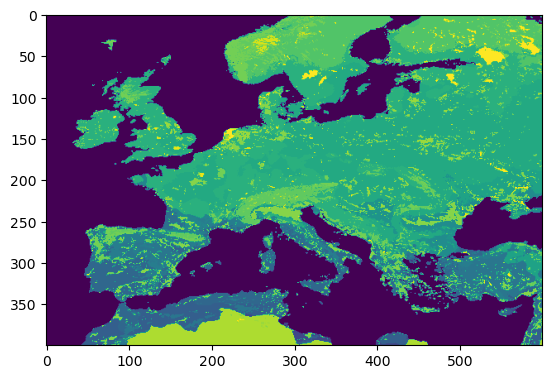

In [44]:
class GlobalAezV4:
    _array = np.array([0])
    _radius_eq, _radius_to_centre = 40_000, 6371 # approx. in km # TODO: These are constants, define as such.
    _csize_km, _csize_deg = 0, 0
    _nrows, _ncols = 0, 0 # for window of interest - zero if no woi
    _lat_start, _long_start = -90, -180 # in degrees

    def load(self, fp, verbose=True, idx=0):
        """Load TIF data as image using LIBTIFF.
            Contains multiple images -> pick highest resolution (i.e. idx = 0) by default. """
        img_container = TIFF.open(fp).iter_images() # returns generator object

        count = 0
        while count <= idx:
            self._array = next(img_container)
            count += 1

        # get latitude cell size
        self._csize_km = self._radius_eq / self._array.shape[1]
        self._csize_deg = 360 / self._array.shape[1]

        # set cells and rows
        self._nrows, self._ncols = self._array.shape

        if verbose:
            # num_images = sum(1 for _ in img_container) - this doesn't work as generators cannot be rewound
            # print(f"TIF container has {num_images} images")
            print("\n Loaded image has resolution: ", self._array.shape)
            print("\n Latitude cell size [km] for that image is: ", self._csize_km)
            print("\n Latitude cell size [deg] for that image is: ", self._csize_deg)

    def set_woi(self, r0=0, c0=0, n_rows=100, n_cols=100):
        """ Select window of interest in row / column format.
        Array indexing starts from upper left corner, which is latitude = + 90 and longitude = -180 (degrees)"""
        self._nrows, self._ncols = n_rows, n_cols

        # set reference point (upper left - northwest) for latitude coordinates
        self._lat_start = 90 - r0 * self._csize_deg
        self._long_start = -180 + c0 * self._csize_deg

        self._array = self._array[r0:r0+n_rows, c0:c0+n_cols]

    def get_distance_matrix(self, verbose=False):
        """
        goal: we have a (n_cols, n_rows, n_rows) matrix. If we query with e.g. index (0, 0, 0),
        we get the distance for relative long. diff 0, and for latitude vals self._xul, self._xul
        instead of np.meshgrid(), we use numpy broadcasting to save memory
        """
        latitudes = np.linspace(self._lat_start, self._lat_start + (self._nrows - 1) * self._csize_deg, self._nrows)
        longitudes_diff = np.linspace(0, (self._ncols -1) * self._csize_deg, self._ncols) # only relative values needed

        # prepare for broadcasting
        longitudes_diff = longitudes_diff[:, None, None]
        lat_vals_x = latitudes[None, :, None]
        lat_vals_y = latitudes[None, None, :]

        # get distance - problem: We have a memory error but broadcasting works like a charm
        num_elements= self._ncols * self._nrows ** 2
        if num_elements > pow(10, 8): # raise error if matrix takes more than ~ 100 MB
            raise MemoryError("Not enough memory can be allocated, consider a smaller window of interest.")

        # convert to radians
        lat_vals_x *= np.pi / 180
        lat_vals_y *= np.pi / 180
        longitudes_diff *= np.pi / 180

        # Apply haversine formula
        a = np.sin((lat_vals_x - lat_vals_y) / 2) ** 2 + \
            np.cos(lat_vals_x) * np.cos(lat_vals_y) * np.sin(longitudes_diff / 2) ** 2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
        distance = self._radius_to_centre * c

        if verbose:
            print("\n Distance matrix has shape ", distance.shape,
                  "\n Window of Interest has colums and rows ", self._ncols, self._nrows)

        return distance


    def get_arc_distance(self):
        """"""
        pass

# Test class
data_dir = r"C:\Users\leoko\Documents\Vienna_CSH\gaez_v4_data"
fn = "aez_33_classes_low_res.tif"

test_class = GlobalAezV4()
test_class.load(os.path.join(data_dir, fn), idx=0)
test_class.set_woi(r0=300, c0=2000, n_rows=400, n_cols=600)
test_class.get_distance_matrix()

plt.imshow(test_class._array)